In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, VGG16, MobileNet, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [2]:
# Veri dizinleri
data_dir = "rice_leaf_data"
train_dir = "data/train"
test_dir = "data/test"

# Veri artırma ve normalizasyon (eğitim için)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.0  # çünkü eğitim ve test veri klasörlerini ayrı vereceğiz
)

# Sadece normalizasyon (test için)
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim verisi generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Test verisi generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Sınıf isimlerini kaydet
class_names = list(train_generator.class_indices.keys())
print("Sınıf isimleri:", class_names)


Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Sınıf isimleri: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


In [3]:
import shutil
import random
from pathlib import Path

# Klasör yolları
source_dir = Path("rice_leaf_data")
train_dir = Path("data/train")
test_dir = Path("data/test")

# Eğitim ve test klasörlerini temizleyip oluştur
for dir_path in [train_dir, test_dir]:
    if dir_path.exists():
        shutil.rmtree(dir_path)
    dir_path.mkdir(parents=True, exist_ok=True)

# Rastgele ve dengeli şekilde bölelim
split_ratio = 0.8

# Her sınıf için ayrı ayrı işlem
for class_folder in source_dir.iterdir():
    if class_folder.is_dir():
        images = list(class_folder.glob("*.*"))
        random.shuffle(images)

        split_index = int(len(images) * split_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Hedef klasörleri oluştur
        (train_dir / class_folder.name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_folder.name).mkdir(parents=True, exist_ok=True)

        # Görselleri kopyala
        for img in train_images:
            shutil.copy(img, train_dir / class_folder.name / img.name)
        for img in test_images:
            shutil.copy(img, test_dir / class_folder.name / img.name)

print("Veri başarıyla eğitim ve test klasörlerine bölündü.")


Veri başarıyla eğitim ve test klasörlerine bölündü.


In [4]:
# Eğitim verisi generator (tekrar)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Test verisi generator (tekrar)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Sınıf isimlerini tekrar yazdıralım
class_names = list(train_generator.class_indices.keys())
print("Sınıf isimleri:", class_names)


Found 4745 images belonging to 4 classes.
Found 1187 images belonging to 4 classes.
Sınıf isimleri: ['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']


In [5]:
def build_model(base_model_class, input_shape=(224, 224, 3), num_classes=4):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # İlk aşamada sadece üst katmanları eğitelim

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Modeli oluştur
xception_model = build_model(Xception)

# Checkpoint ve early stopping ayarları
checkpoint_path = "models/xception_best_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Modeli eğit
history_xception = xception_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.6348 - loss: 0.9565

149/149 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6356 - loss: 0.9549 - val_accuracy: 0.8517 - val_loss: 0.4374
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8846 - loss: 0.3844

149/149 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.8845 - loss: 0.3843 - val_accuracy: 0.9014 - val_loss: 0.3089
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9159 - loss: 0.2826

149/149 ━━━━━━━━━━━━━━━━━━━━ 670s 4s/step - accuracy: 0.9159 - loss: 0.2826 - val_accuracy: 0.9233 - val_loss: 0.2512
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9170 - loss: 0.2565

149/149 ━━━━━━━━━━━━━━━━━━━━ 593s 4s/step - accuracy: 0.9170 - loss: 0.2565 - val_accuracy: 0.9267 - val_loss: 0.2237
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9320 - loss: 0.2141

149/149 ━━━━━━━━━━━━━━━━━━━━ 829s 5s/step - accuracy: 0.9320 - loss: 0.2141 - val_accuracy: 0.9334 - val_loss: 0.2013
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9342 - loss: 0.1987

149/149 ━━━━━━━━━━━━━━━━━━━━ 893s 6s/step - accuracy: 0.9343 - loss: 0.1987 - val_accuracy: 0.9368 - val_loss: 0.1857
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9388 - loss: 0.1893

149/149 ━━━━━━━━━━━━━━━━━━━━ 783s 5s/step - accuracy: 0.9389 - loss: 0.1892 - val_accuracy: 0.9368 - val_loss: 0.1737
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9483 - loss: 0.1604

149/149 ━━━━━━━━━━━━━━━━━━━━ 797s 5s/step - accuracy: 0.9483 - loss: 0.1605 - val_accuracy: 0.9469 - val_loss: 0.1610
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9569 - loss: 0.1496

149/149 ━━━━━━━━━━━━━━━━━━━━ 725s 5s/step - accuracy: 0.9569 - loss: 0.1497 - val_accuracy: 0.9570 - val_loss: 0.1477
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9559 - loss: 0.1411

149/149 ━━━━━━━━━━━━━━━━━━━━ 689s 5s/step - accuracy: 0.9559 - loss: 0.1411 - val_accuracy: 0.9612 - val_loss: 0.1440
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9614 - loss: 0.1312

149/149 ━━━━━━━━━━━━━━━━━━━━ 825s 5s/step - accuracy: 0.9614 - loss: 0.1313 - val_accuracy: 0.9562 - val_loss: 0.1297
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9599 - loss: 0.1283

149/149 ━━━━━━━━━━━━━━━━━━━━ 799s 5s/step - accuracy: 0.9599 - loss: 0.1283 - val_accuracy: 0.9663 - val_loss: 0.1185
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9694 - loss: 0.1092

149/149 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9694 - loss: 0.1092 - val_accuracy: 0.9688 - val_loss: 0.1078
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9660 - loss: 0.1105

149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9660 - loss: 0.1105 - val_accuracy: 0.9722 - val_loss: 0.1074
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.9642 - loss: 0.1118

149/149 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9642 - loss: 0.1118 - val_accuracy: 0.9764 - val_loss: 0.1039
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9698 - loss: 0.0999 - val_accuracy: 0.9739 - val_loss: 0.1125
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9782 - loss: 0.0884

149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9782 - loss: 0.0884 - val_accuracy: 0.9764 - val_loss: 0.0931
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9708 - loss: 0.0955 - val_accuracy: 0.9764 - val_loss: 0.0957
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9714 - loss: 0.0945

149/149 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9714 - loss: 0.0945 - val_accuracy: 0.9773 - val_loss: 0.0878
Epoch 20/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9743 - loss: 0.0847 - val_accuracy: 0.9823 - val_loss: 0.0894
Epoch 21/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9736 - loss: 0.0850 - val_accuracy: 0.9773 - val_loss: 0.0898
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9707 - loss: 0.0851

149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9708 - loss: 0.0851 - val_accuracy: 0.9815 - val_loss: 0.0853
Epoch 23/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9734 - loss: 0.0769

149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9734 - loss: 0.0769 - val_accuracy: 0.9832 - val_loss: 0.0823
Epoch 24/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9746 - loss: 0.0820

149/149 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9746 - loss: 0.0820 - val_accuracy: 0.9815 - val_loss: 0.0712
Epoch 25/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9740 - loss: 0.0797

149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9740 - loss: 0.0797 - val_accuracy: 0.9848 - val_loss: 0.0685
Epoch 26/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9846 - loss: 0.0644

149/149 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9846 - loss: 0.0644 - val_accuracy: 0.9874 - val_loss: 0.0658
Epoch 27/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9828 - loss: 0.0652

149/149 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9827 - loss: 0.0652 - val_accuracy: 0.9848 - val_loss: 0.0657
Epoch 28/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9837 - loss: 0.0641 - val_accuracy: 0.9832 - val_loss: 0.0662
Epoch 29/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.9841 - loss: 0.0621

149/149 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9841 - loss: 0.0621 - val_accuracy: 0.9840 - val_loss: 0.0636
Epoch 30/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9808 - loss: 0.0634 - val_accuracy: 0.9806 - val_loss: 0.0723


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# VGG16 modeli oluştur
vgg16_model = build_model(VGG16)

# Checkpoint ve early stopping ayarları
checkpoint_path_vgg = "models/vgg16_best_model.h5"
callbacks_vgg = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path_vgg, monitor='val_loss', save_best_only=True)
]

# Modeli eğit
history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks_vgg
)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3836 - loss: 1.3277

149/149 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.3844 - loss: 1.3271 - val_accuracy: 0.6706 - val_loss: 1.0872
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7093 - loss: 1.0493

149/149 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.7093 - loss: 1.0490 - val_accuracy: 0.7254 - val_loss: 0.9023
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7232 - loss: 0.9096

149/149 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7233 - loss: 0.9094 - val_accuracy: 0.7338 - val_loss: 0.7957
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7481 - loss: 0.8006

149/149 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7482 - loss: 0.8004 - val_accuracy: 0.7405 - val_loss: 0.7102
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7539 - loss: 0.7285

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7539 - loss: 0.7283 - val_accuracy: 0.7523 - val_loss: 0.6564
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7946 - loss: 0.6575

149/149 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.7945 - loss: 0.6575 - val_accuracy: 0.7633 - val_loss: 0.6172
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8017 - loss: 0.6175

149/149 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8016 - loss: 0.6175 - val_accuracy: 0.7784 - val_loss: 0.5794
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8016 - loss: 0.5807

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8016 - loss: 0.5807 - val_accuracy: 0.7928 - val_loss: 0.5449
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8096 - loss: 0.5492

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8096 - loss: 0.5492 - val_accuracy: 0.8079 - val_loss: 0.5161
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8065 - loss: 0.5216

149/149 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8065 - loss: 0.5216 - val_accuracy: 0.8062 - val_loss: 0.4902
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8206 - loss: 0.5036

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8207 - loss: 0.5035 - val_accuracy: 0.8113 - val_loss: 0.4725
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8315 - loss: 0.4727

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8315 - loss: 0.4728 - val_accuracy: 0.8189 - val_loss: 0.4566
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8386 - loss: 0.4667

149/149 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.8386 - loss: 0.4666 - val_accuracy: 0.8265 - val_loss: 0.4409
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8355 - loss: 0.4467

149/149 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8355 - loss: 0.4466 - val_accuracy: 0.8332 - val_loss: 0.4293
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8465 - loss: 0.4387

149/149 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8465 - loss: 0.4386 - val_accuracy: 0.8357 - val_loss: 0.4180
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8619 - loss: 0.4107

149/149 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8618 - loss: 0.4107 - val_accuracy: 0.8492 - val_loss: 0.4019
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8520 - loss: 0.4076

149/149 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.8520 - loss: 0.4076 - val_accuracy: 0.8467 - val_loss: 0.3898
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8601 - loss: 0.3933

149/149 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8600 - loss: 0.3933 - val_accuracy: 0.8484 - val_loss: 0.3836
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8679 - loss: 0.3718

149/149 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8678 - loss: 0.3719 - val_accuracy: 0.8509 - val_loss: 0.3789
Epoch 20/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8724 - loss: 0.3619

149/149 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.8724 - loss: 0.3619 - val_accuracy: 0.8526 - val_loss: 0.3604
Epoch 21/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8755 - loss: 0.3477

149/149 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.8755 - loss: 0.3477 - val_accuracy: 0.8576 - val_loss: 0.3561
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8750 - loss: 0.3548

149/149 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.8750 - loss: 0.3548 - val_accuracy: 0.8559 - val_loss: 0.3470
Epoch 23/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8887 - loss: 0.3365

149/149 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.8887 - loss: 0.3366 - val_accuracy: 0.8618 - val_loss: 0.3462
Epoch 24/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8795 - loss: 0.3438

149/149 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8795 - loss: 0.3438 - val_accuracy: 0.8686 - val_loss: 0.3373
Epoch 25/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8769 - loss: 0.3468

149/149 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.8769 - loss: 0.3467 - val_accuracy: 0.8694 - val_loss: 0.3262
Epoch 26/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8940 - loss: 0.3102

149/149 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.8939 - loss: 0.3103 - val_accuracy: 0.8736 - val_loss: 0.3245
Epoch 27/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8888 - loss: 0.3106

149/149 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.8888 - loss: 0.3106 - val_accuracy: 0.8753 - val_loss: 0.3149
Epoch 28/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8890 - loss: 0.3143

149/149 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.8890 - loss: 0.3143 - val_accuracy: 0.8770 - val_loss: 0.3116
Epoch 29/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8909 - loss: 0.3169

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8909 - loss: 0.3168 - val_accuracy: 0.8846 - val_loss: 0.3063
Epoch 30/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8848 - loss: 0.3179

149/149 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8849 - loss: 0.3178 - val_accuracy: 0.8711 - val_loss: 0.3057


In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# MobileNet modeli oluştur
mobilenet_model = build_model(MobileNet)

# Checkpoint ve early stopping ayarları
checkpoint_path_mobile = "models/mobilenet_best_model.h5"
callbacks_mobile = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path_mobile, monitor='val_loss', save_best_only=True)
]

# Modeli eğit
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks_mobile
)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6430 - loss: 0.9138

149/149 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.6438 - loss: 0.9119 - val_accuracy: 0.8871 - val_loss: 0.3394
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9022 - loss: 0.3027

149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9022 - loss: 0.3025 - val_accuracy: 0.9259 - val_loss: 0.2251
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9389 - loss: 0.2029

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 360ms/step - accuracy: 0.9389 - loss: 0.2028 - val_accuracy: 0.9444 - val_loss: 0.1670
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9513 - loss: 0.1612

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9513 - loss: 0.1611 - val_accuracy: 0.9537 - val_loss: 0.1323
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9666 - loss: 0.1286

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.9666 - loss: 0.1285 - val_accuracy: 0.9621 - val_loss: 0.1106
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9674 - loss: 0.1168

149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.9674 - loss: 0.1167 - val_accuracy: 0.9722 - val_loss: 0.0905
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9748 - loss: 0.0998

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 360ms/step - accuracy: 0.9748 - loss: 0.0997 - val_accuracy: 0.9764 - val_loss: 0.0743
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9828 - loss: 0.0744

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 363ms/step - accuracy: 0.9828 - loss: 0.0744 - val_accuracy: 0.9815 - val_loss: 0.0645
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9831 - loss: 0.0694

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.9831 - loss: 0.0694 - val_accuracy: 0.9815 - val_loss: 0.0581
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9840 - loss: 0.0647

149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 421ms/step - accuracy: 0.9840 - loss: 0.0647 - val_accuracy: 0.9840 - val_loss: 0.0501
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9880 - loss: 0.0547

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.9880 - loss: 0.0547 - val_accuracy: 0.9882 - val_loss: 0.0452
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9887 - loss: 0.0528

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - accuracy: 0.9887 - loss: 0.0527 - val_accuracy: 0.9874 - val_loss: 0.0434
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9910 - loss: 0.0453

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9910 - loss: 0.0453 - val_accuracy: 0.9848 - val_loss: 0.0421
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9877 - loss: 0.0476

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9877 - loss: 0.0476 - val_accuracy: 0.9899 - val_loss: 0.0364
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 359ms/step - accuracy: 0.9916 - loss: 0.0397 - val_accuracy: 0.9865 - val_loss: 0.0379
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9874 - loss: 0.0426

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 358ms/step - accuracy: 0.9874 - loss: 0.0426 - val_accuracy: 0.9874 - val_loss: 0.0353
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9912 - loss: 0.0346

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9912 - loss: 0.0346 - val_accuracy: 0.9916 - val_loss: 0.0273
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.9922 - loss: 0.0300 - val_accuracy: 0.9890 - val_loss: 0.0312
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.9935 - loss: 0.0315 - val_accuracy: 0.9924 - val_loss: 0.0291
Epoch 20/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9921 - loss: 0.0298

149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 361ms/step - accuracy: 0.9921 - loss: 0.0298 - val_accuracy: 0.9958 - val_loss: 0.0214
Epoch 21/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.9937 - loss: 0.0322 - val_accuracy: 0.9916 - val_loss: 0.0261
Epoch 22/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9936 - loss: 0.0253

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.9936 - loss: 0.0253 - val_accuracy: 0.9949 - val_loss: 0.0207
Epoch 23/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.9933 - loss: 0.0295 - val_accuracy: 0.9941 - val_loss: 0.0215
Epoch 24/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9955 - loss: 0.0218

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9955 - loss: 0.0218 - val_accuracy: 0.9949 - val_loss: 0.0189
Epoch 25/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9979 - loss: 0.0161

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9979 - loss: 0.0161 - val_accuracy: 0.9958 - val_loss: 0.0168
Epoch 26/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9976 - loss: 0.0184

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 356ms/step - accuracy: 0.9976 - loss: 0.0184 - val_accuracy: 0.9983 - val_loss: 0.0146
Epoch 27/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.9955 - loss: 0.0204 - val_accuracy: 0.9933 - val_loss: 0.0201
Epoch 28/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 357ms/step - accuracy: 0.9971 - loss: 0.0187 - val_accuracy: 0.9949 - val_loss: 0.0212
Epoch 29/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.9966 - loss: 0.0169 - val_accuracy: 0.9949 - val_loss: 0.0147
Epoch 30/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9938 - loss: 0.0187

149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.9938 - loss: 0.0187 - val_accuracy: 0.9949 - val_loss: 0.0119


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Daha fazla katmanı açık bırak
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Daha düşük learning rate
resnet_model.compile(optimizer=Adam(learning_rate=5e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Daha sabırlı early stopping
checkpoint_path_resnet = "models/resnet50_best_model_v2.h5"
callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path_resnet, monitor='val_loss', save_best_only=True)
]

# Eğit
history_resnet = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks_resnet
)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4813 - loss: 1.1826

149/149 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.4817 - loss: 1.1819 - val_accuracy: 0.2426 - val_loss: 1.4538
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6370 - loss: 0.8771 - val_accuracy: 0.2544 - val_loss: 1.6420
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.6962 - loss: 0.7810

149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.6962 - loss: 0.7810 - val_accuracy: 0.4853 - val_loss: 1.3127
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7210 - loss: 0.7371 - val_accuracy: 0.5611 - val_loss: 1.7972
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7377 - loss: 0.6834 - val_accuracy: 0.5240 - val_loss: 1.3789
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 0.7434 - loss: 0.6541

149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7434 - loss: 0.6540 - val_accuracy: 0.7801 - val_loss: 0.5802
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7552 - loss: 0.6235 - val_accuracy: 0.7675 - val_loss: 0.6227
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7702 - loss: 0.5853 - val_accuracy: 0.6622 - val_loss: 0.7221
Epoch 9/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.7828 - loss: 0.5765

149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7827 - loss: 0.5765 - val_accuracy: 0.8037 - val_loss: 0.5308
Epoch 10/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7692 - loss: 0.5863 - val_accuracy: 0.6976 - val_loss: 0.7884
Epoch 11/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7805 - loss: 0.5579 - val_accuracy: 0.7456 - val_loss: 0.7207
Epoch 12/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8028 - loss: 0.5318 - val_accuracy: 0.5046 - val_loss: 2.2528
Epoch 13/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7959 - loss: 0.5202

149/149 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7959 - loss: 0.5203 - val_accuracy: 0.8248 - val_loss: 0.4258
Epoch 14/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.8020 - loss: 0.4852 - val_accuracy: 0.4448 - val_loss: 1.4763
Epoch 15/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8100 - loss: 0.4868 - val_accuracy: 0.6917 - val_loss: 0.9354
Epoch 16/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7969 - loss: 0.4954 - val_accuracy: 0.5931 - val_loss: 1.0097
Epoch 17/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8173 - loss: 0.4694 - val_accuracy: 0.5569 - val_loss: 1.1150
Epoch 18/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8272 - loss: 0.4497 - val_accuracy: 0.6596 - val_loss: 1.3835
Epoch 19/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8273 - loss: 0.4491 - val_accuracy: 0.7650 - val_loss: 0.6646
Epoch 20/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8289 - loss: 0.4380 - val_accuracy

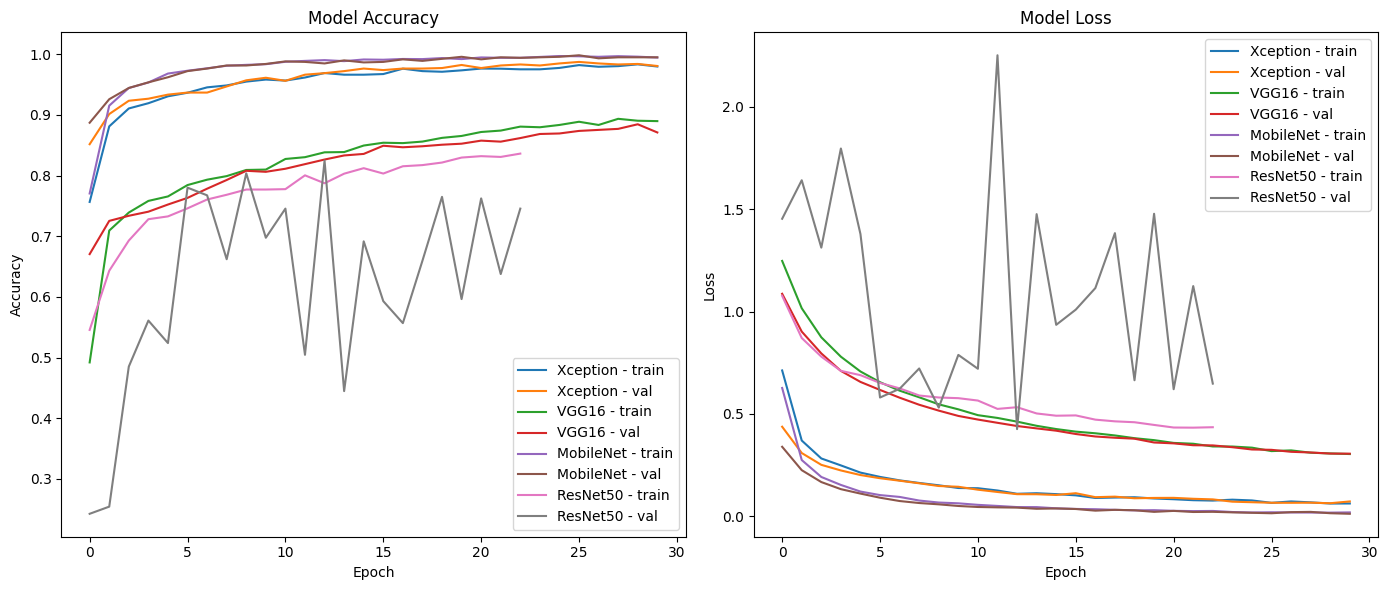

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} - train')
        plt.plot(history.history['val_accuracy'], label=f'{name} - val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - train')
        plt.plot(history.history['val_loss'], label=f'{name} - val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Eğitim geçmişlerini uygun sırayla gir
plot_training_history(
    histories=[history_xception, history_vgg16, history_mobilenet, history_resnet],
    model_names=["Xception", "VGG16", "MobileNet", "ResNet50"]
)



----- Xception -----


38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


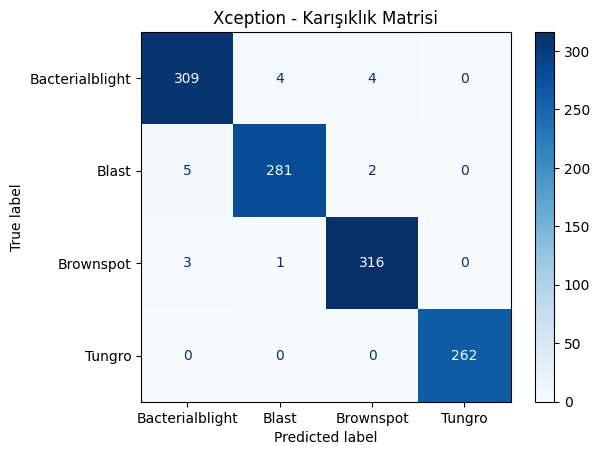

Xception - Classification Report
                 precision    recall  f1-score   support

Bacterialblight       0.97      0.97      0.97       317
          Blast       0.98      0.98      0.98       288
      Brownspot       0.98      0.99      0.98       320
         Tungro       1.00      1.00      1.00       262

       accuracy                           0.98      1187
      macro avg       0.98      0.98      0.98      1187
   weighted avg       0.98      0.98      0.98      1187


----- VGG16 -----
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step


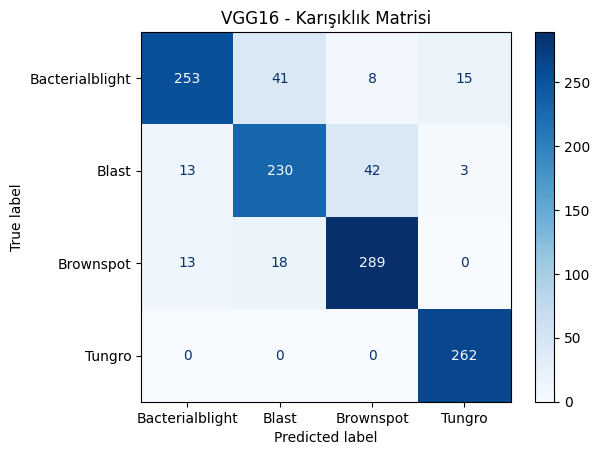

VGG16 - Classification Report
                 precision    recall  f1-score   support

Bacterialblight       0.91      0.80      0.85       317
          Blast       0.80      0.80      0.80       288
      Brownspot       0.85      0.90      0.88       320
         Tungro       0.94      1.00      0.97       262

       accuracy                           0.87      1187
      macro avg       0.87      0.87      0.87      1187
   weighted avg       0.87      0.87      0.87      1187


----- MobileNet -----


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step


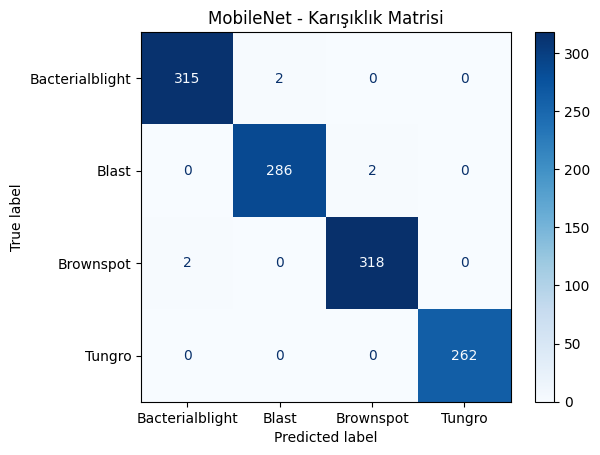

MobileNet - Classification Report
                 precision    recall  f1-score   support

Bacterialblight       0.99      0.99      0.99       317
          Blast       0.99      0.99      0.99       288
      Brownspot       0.99      0.99      0.99       320
         Tungro       1.00      1.00      1.00       262

       accuracy                           0.99      1187
      macro avg       1.00      1.00      1.00      1187
   weighted avg       0.99      0.99      0.99      1187


----- ResNet50 -----


38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 690ms/step


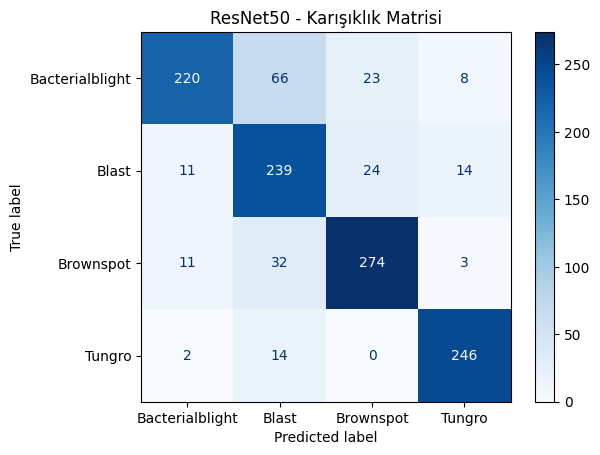

ResNet50 - Classification Report
                 precision    recall  f1-score   support

Bacterialblight       0.90      0.69      0.78       317
          Blast       0.68      0.83      0.75       288
      Brownspot       0.85      0.86      0.85       320
         Tungro       0.91      0.94      0.92       262

       accuracy                           0.82      1187
      macro avg       0.84      0.83      0.83      1187
   weighted avg       0.84      0.82      0.83      1187



In [20]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Model isimleri ve .h5 dosyalarının yolları
model_paths = {
    'Xception': 'models/xception_best_model.h5',
    'VGG16': 'models/vgg16_best_model.h5',
    'MobileNet': 'models/mobilenet_best_model.h5',
    'ResNet50': 'models/resnet50_best_model_v2.h5'  # <- DÜZELTİLDİ
}

# Sınıf isimleri (generator'dan alınıyor)
class_names = list(test_generator.class_indices.keys())

# Gerçek etiketler (one-hot değilse direkt alınabilir)
y_true = test_generator.classes

# Her model için tahmin, karışıklık matrisi ve classification report
for name, path in model_paths.items():
    print(f"\n----- {name} -----")
    model = load_model(path)
    
    # Tahminler
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Karışıklık Matrisi
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Karışıklık Matrisi")
    plt.show()

    # Classification Report
    print(f"{name} - Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [21]:
from sklearn.metrics import classification_report
import pandas as pd

# Model yolları
model_paths = {
    'Xception': 'models/xception_best_model.h5',
    'VGG16': 'models/vgg16_best_model.h5',
    'MobileNet': 'models/mobilenet_best_model.h5',
    'ResNet50': 'models/resnet50_best_model_v2.h5'
}

# Sonuçları tutmak için
results = []

for name, path in model_paths.items():
    model = load_model(path)
    
    # Tahminler
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Rapor
    report = classification_report(test_generator.classes, y_pred, output_dict=True)
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

# DataFrame'e dök ve yazdır
df_results = pd.DataFrame(results)
print(df_results)


38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step


38/38 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step


38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 659ms/step
       Model  Accuracy  Precision  Recall  F1-Score
0   Xception    0.9840     0.9847  0.9845    0.9846
1      VGG16    0.8711     0.8727  0.8750    0.8725
2  MobileNet    0.9949     0.9951  0.9951    0.9951
3   ResNet50    0.8248     0.8360  0.8298    0.8276


In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Test verilerini NumPy dizilerine dönüştür
X_test, y_test = [], []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    X_test.append(x_batch)
    y_test.append(y_batch)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Gerçek ve tahmin etiketleri
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(xception_model.predict(X_test), axis=1)

# Sınıf isimlerini test generator'dan al
class_names = list(test_generator.class_indices.keys())

# Sınıflandırma raporu
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_classification = pd.DataFrame(report).transpose()

# Raporu yazdır
print(df_classification)


38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
                 precision    recall  f1-score      support
Bacterialblight   0.526767  0.776025  0.627551   317.000000
Blast             0.607692  0.274306  0.377990   288.000000
Brownspot         0.610738  0.853125  0.711864   320.000000
Tungro            0.867133  0.473282  0.612346   262.000000
accuracy          0.608256  0.608256  0.608256     0.608256
macro avg         0.653083  0.594185  0.582438  1187.000000
weighted avg      0.644166  0.608256  0.586374  1187.000000


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Test verisini yükle (tek seferlik)
X_test, y_test = [], []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    X_test.append(x_batch)
    y_test.append(y_batch)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_true = np.argmax(y_test, axis=1)

# Sınıf adları
class_names = list(test_generator.class_indices.keys())

# Modeller
models = {
    "Xception": xception_model,
    "VGG16": vgg16_model,
    "MobileNet": mobilenet_model,
    "ResNet50": resnet_model
}

# Sonuçları birleştirmek için liste
summary_list = []

for model_name, model in models.items():
    print(f"\n--- {model_name} Sınıflandırma Raporu ---")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Rapor al
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, output_dict=True
    )

    # DataFrame olarak yazdır
    df = pd.DataFrame(report_dict).transpose()
    print(df)

    # Özet metrikleri ayrı bir tabloya al
    summary_list.append({
        "Model": model_name,
        "Accuracy": report_dict["accuracy"],
        "Precision": report_dict["weighted avg"]["precision"],
        "Recall": report_dict["weighted avg"]["recall"],
        "F1-Score": report_dict["weighted avg"]["f1-score"]
    })

# Özet tablo
summary_df = pd.DataFrame(summary_list)
print("\n=== MODELLERİN ÖZET KARŞILAŞTIRMASI ===")
print(summary_df)

# CSV olarak kaydetmek istersen:
summary_df.to_csv("model_comparison_summary.csv", index=False)



--- Xception Sınıflandırma Raporu ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step
                 precision    recall  f1-score      support
Bacterialblight   0.526767  0.776025  0.627551   317.000000
Blast             0.607692  0.274306  0.377990   288.000000
Brownspot         0.610738  0.853125  0.711864   320.000000
Tungro            0.867133  0.473282  0.612346   262.000000
accuracy          0.608256  0.608256  0.608256     0.608256
macro avg         0.653083  0.594185  0.582438  1187.000000
weighted avg      0.644166  0.608256  0.586374  1187.000000

--- VGG16 Sınıflandırma Raporu ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step
                 precision    recall  f1-score      support
Bacterialblight   0.906810  0.798107  0.848993   317.000000
Blast             0.795848  0.798611  0.797227   288.000000
Brownspot         0.852507  0.903125  0.877086   320.000000
Tungro            0.935714  1.000000  0.966790   262.000000
accuracy          0.871104  0.871104  0.871104     0.871104
macr

In [28]:
import time

models = {
    "Xception": xception_model,
    "VGG16": vgg16_model,
    "MobileNet": mobilenet_model,
    "ResNet50": resnet_model
}

# Her modelin ilk 10 test görüntüsüne tahmin süresini hesapla
for model_name, model in models.items():
    start = time.time()
    _ = model.predict(X_test[:10])
    end = time.time()
    print(f"{model_name} 10 görüntü tahmin süresi: {end - start:.4f} saniye")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Xception 10 görüntü tahmin süresi: 0.3925 saniye
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
VGG16 10 görüntü tahmin süresi: 0.6343 saniye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
MobileNet 10 görüntü tahmin süresi: 0.1406 saniye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
ResNet50 10 görüntü tahmin süresi: 0.2866 saniye


In [2]:
from tensorflow.keras.models import load_model

model_paths = {
    "Xception": "models/xception_best_model.h5",
    "VGG16": "models/vgg16_best_model.h5",
    "MobileNet": "models/mobilenet_best_model.h5",
    "ResNet50": "models/resnet50_best_model.h5"
}

for name, path in model_paths.items():
    print(f"\n{name} Model Özeti:")
    model = load_model(path)
    model.summary()



Xception Model Özeti:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_12[0][0]    

 Total params: 21,124,270 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2 (12.00 B)


VGG16 Model Özeti:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,870 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)


MobileNet Model Özeti:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,360,582 (12.82 MB)

 Trainable params: 131,716 (514.52 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 2 (12.00 B)


ResNet50 Model Özeti:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,502 (90.98 MB)

 Trainable params: 14,712,964 (56.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

 Optimizer params: 2 (12.00 B)

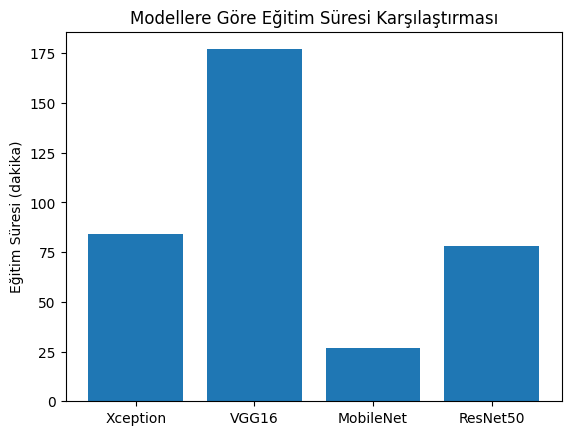

In [4]:
import matplotlib.pyplot as plt

model_names = ['Xception', 'VGG16', 'MobileNet', 'ResNet50']
training_times_minutes = [84, 177, 27, 78]

plt.bar(model_names, training_times_minutes)
plt.ylabel("Eğitim Süresi (dakika)")
plt.title("Modellere Göre Eğitim Süresi Karşılaştırması")
plt.savefig("results/training_time_comparison.png")
plt.show()
